In [1]:
import localcider
from localcider.sequenceParameters import SequenceParameters
import protfasta
import glob
import pandas as pd
import numpy as np
import re
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict 
from Bio.Seq import Seq
import Bio
import matplotlib.patches as mpatches
import seaborn as sns
lightblue , darkblue, lightgreen, darkgreen, pink =  '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99'
import editdistance

import YeastAnalysisfunctions as YAF

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['pdf.fonttype'] = 42

# alignment distance vs activity difference 
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import time

In [8]:
masterDF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20240930_withSeqFeatures.csv')
maxActivity = max(masterDF.Activity_SCglucose)
minActivity = min(masterDF[masterDF.Recovered].Activity_SCglucose)

Activity = 'Activity_SCglucose'
print('%i of %i Designed ADs recovered, %.1f percent'%(sum(masterDF['Recovered']),len(masterDF),100.0*sum(masterDF['Recovered'])/len(masterDF)))


# ActivityThresh = 100000
# ActivityThresh=45373 #new thresholds from Aaron's model June 2024
# HighActivityThresh=45373*2
ActivityThresh=  94031 # 80th percentile 20241001


#define WT
ScerWTactivity = np.mean(masterDF[masterDF.ADseq=='STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK'][Activity])
ScerWT_DF = masterDF[masterDF.ADseq=='STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK']

Orthologs_DF = pd.read_csv('../Data/Processed/OrthologTilingDFwActivities_20240930.csv')

FullOrthoDF =  pd.read_pickle('../Data/Processed/FullOrthologDF_20240930')

18947 of 20731 Designed ADs recovered, 91.4 percent


# make a pretty WT Gcn4 plot

In [9]:
# Define the Scer WT for comparison
def MakeDF1Ortholog(SpeciesName='Saccharomycotina_sp|P03069|GCN4_YEAST'):
    indx = (Orthologs_DF.SpeciesNames ==SpeciesName)&(Orthologs_DF.Activity>0)
    ScertempDF = Orthologs_DF[indx]
    ScertempDF = ScertempDF.sort_values(by='NativeLocation',ascending=False)
    # for i,row in ScertempDF.iterrows():
    # #     print(row)
    #     print(row.Seq)
    #     print(row.Activity)
    #     print(row.NativeLocation)
    return ScertempDF
ScertempDF = MakeDF1Ortholog()
ScertempDF.to_csv('Figures/Scer_WT_Data.csv')

Gcn4 AltCAAD
40 AA with 5 helicies and 0 regions


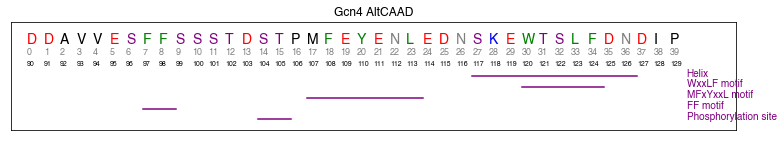

Gcn4 CAAD
40 AA with 4 helicies and 0 regions


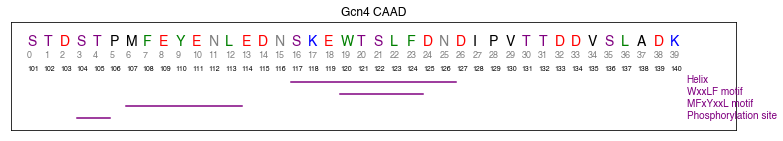

In [10]:
def visualize_Candidate_AD(AD,EndogenousLocation,ADname='',HelixLocationList=[],RegionsToMut=[]):
    KeyHydros = ['W','F','Y','L']
    Acidic = ['D','E']
    Basic = ['K','R']
    QsNs = ['Q','N']
    SGT = ['S','G','T']
    fig3, axes = plt.subplots( figsize=(13,2))
    print( ADname)
    print( '%s AA with %i helicies and %i regions'%(len(AD),len(HelixLocationList),len(RegionsToMut)))
    ypos = 0
    for pos, ADaa in enumerate(AD):
        if ADaa in KeyHydros:
            plt.text(pos,ypos, ADaa, color='green',fontsize=14, fontweight='bold')
        elif ADaa in Acidic:
            plt.text(pos,ypos, ADaa, color='r',fontsize=14, fontweight='bold')
        elif ADaa in Basic:
            plt.text(pos,ypos, ADaa, color='b',fontsize=14, fontweight='bold')
        elif ADaa in QsNs:
            plt.text(pos,ypos, ADaa, color='gray',fontsize=14, fontweight='bold')
        elif ADaa in SGT:
            plt.text(pos,ypos, ADaa, color='purple',fontsize=14, fontweight='bold')
        else:
            plt.text(pos,ypos, ADaa, color='k',fontsize=14, fontweight='bold')
        # label the positions
        plt.text(pos,ypos+1,pos,color='gray',fontsize=9)
        plt.text(pos,ypos+2,pos+EndogenousLocation[0],color='k',fontsize=7 )
    ypos +=3
    
    
    #plot helixes
    for helix in HelixLocationList:
        plt.plot([helix[0],helix[1]+1],[ypos,ypos],color='purple')
        plt.text(pos+1,ypos,helix[2],color='purple')
        ypos +=1
    #plot the regions to mutate or shuffle
    for region in RegionsToMut:
        plt.plot([region[0],region[1]],[ypos,ypos],color='teal')
        ypos +=1
        
    plt.axis([-1, pos+4, ypos,-2])
    plt.xticks([]),    plt.yticks([])
    plt.title(ADname)
    plt.savefig('Figures/Annotated_'+ADname+'.png')
    plt.show()

visualize_Candidate_AD('DDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIP',[90,129],'Gcn4 AltCAAD',HelixLocationList=[[27,36,'Helix'],
                                                                                                                [30,34,'WxxLF motif'],
                                                                                                                [17,23,'MFxYxxL motif'],
                                                                                                                [7,8,'FF motif'],
                                                                                                                [14,15,'Phosphorylation site']])
offset = -11
visualize_Candidate_AD('STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK',[101,140],'Gcn4 CAAD',HelixLocationList=[[27+offset,36+offset,'Helix'],
                                                                                                                [30+offset,34+offset,'WxxLF motif'],
                                                                                                                [17+offset,23+offset,'MFxYxxL motif'],
#                                                                                                                 [7,8,'FF motif'],
                                                                                                                [14+offset,15+offset,'Phosphorylation site']])

In [11]:
masterDF.Stdev_BYS4_BioReps Stdev_BSY4_BioReps

SyntaxError: invalid syntax (386633958.py, line 1)

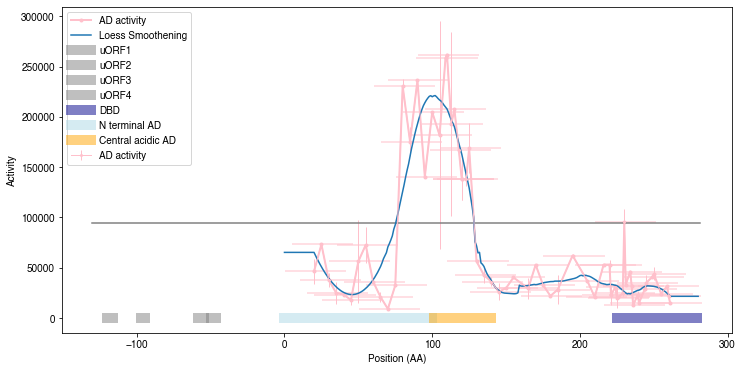

In [12]:


# other features
Gcn4Features = {"uORF1":[-360./3,-349/3,'gray'] ,
'uORF2':[-292./3,-284/3,'gray'],
'uORF3':[-175./3,-164/3,'gray'],
'uORF4':[-150./3,-139/3,'gray'],
                'DBD':[225,279,'darkblue'],
                'N terminal AD':[0,100,'lightblue'],
                'Central acidic AD':[101,140,'orange']
               }
# 'CDS':[1..846]# (includes STOP)
tracecolor ='pink'
x = 'NativeLocation'# 
y = 'Activity'
halfwindow =20 
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(1,1,1)
# Define the Scer WT for comparison
ScertempDF = pd.read_csv('Figures/Scer_WT_Data.csv')

ax.plot(ScertempDF[x],ScertempDF[y],c=tracecolor,linewidth=2,marker='.',label='AD activity')
# ax.scatter(ScertempDF[x],ScertempDF[y],c=tracecolor,linewidth=2,marker='o',label='AD activity')
ax.errorbar(ScertempDF[x],ScertempDF[y],yerr=ScertempDF['Stdev_BYS4_BioReps'],c='pink',mfc=tracecolor,linewidth=1,marker='.',mew=0,label='AD activity')


for i, entry in ScertempDF.iterrows():
    ax.plot([entry[x]+1-halfwindow,entry[x]+1+halfwindow],[entry[y],entry[y]],linewidth=2,c=tracecolor,alpha=.5)
ax.plot([-130,281],[ActivityThresh,ActivityThresh],c='gray')
tempDF = FullOrthoDF[FullOrthoDF.SpeciesName=='Saccharomycotina_sp|P03069|GCN4_YEAST']
# ax.plot(tempDF.SmoothedActivites.values[0],label='Average smoothening')
ax.plot(tempDF.SmoothedActivitesLoess.values[0],label='Loess Smoothening')
# ax.plot(tempDF.SmoothedActivites)

for i in Gcn4Features.keys():
    x1,x2,color = Gcn4Features[i]
    ax.plot([x1,x2],[1,1],c=color,linewidth=10,alpha=.5,label=i)
plt.xlabel('Position (AA)'),plt.ylabel('Activity')
plt.legend(loc=2)
plt.savefig('../Results/AnnotatedGcn4_smoothing.pdf')
plt.show()

In [6]:
print('Scer activity at WxxLF motif is %f '%tempDF.SmoothedActivitesLoess.values[0][119])


Scer activity at WxxLF motif is 169458.043561 


# figure to show mutation diversity

2161
696
1453


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_86133/129299755.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


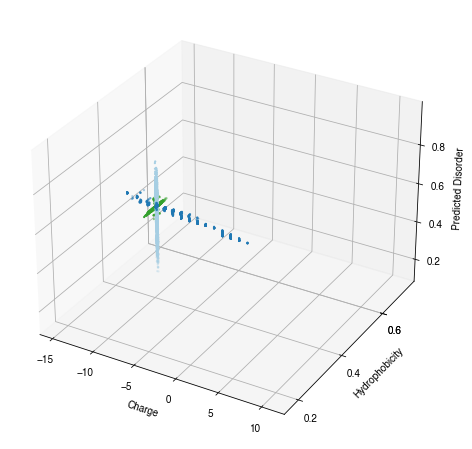

In [7]:
PublishedGcn4Data = pd.read_csv('../Data/Staller_2018data/Supplemental_DataTable1_ActivityData.csv')

Merged_DF = PublishedGcn4Data
#high light each perturbation
markersize = 5
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
DF = Merged_DF[Merged_DF.MutationClass=='Charge']
print( len(DF))
ax.scatter(DF.Charge,DF.Hydrophobicity,DF.Disorder,label='Charge variants',color=darkblue,edgecolors='none',s=markersize)
DF = Merged_DF[Merged_DF.MutationClass=='Hydrophobicity']
print( len(DF))
ax.scatter(DF.Charge,DF.Hydrophobicity,DF.Disorder,label='Hydrophobicity variants',color=darkgreen,edgecolors='none',s=markersize)
DF = Merged_DF[Merged_DF.MutationClass=='Disorder']
print( len(DF))
ax.scatter(DF.Charge,DF.Hydrophobicity,DF.Disorder,label='Disorder variants',color=lightblue,edgecolors='none',s=markersize)
#DF = Merged_DF[Merged_DF.MutationClass=='Kappa']
#ax.scatter(DF.Charge,DF.Hydrophobicity,DF.Disorder,s=100,label='Kappa variants',color=pink)

# DATA_Gcn4_singleMuts = pickle.load(open('../AnalysisSupportFiles/Dump_Gcn4_singleMuts.txt','r')) # uses old 9 column format 
# ax.scatter( np.array(DATA_Gcn4_singleMuts[2])*44,DATA_Gcn4_singleMuts[3],DATA_Gcn4_singleMuts[7],color=lightgreen,edgecolors='none',s=markersize,label='Gcn4 Single mutants')

# gcn4 = pickle.load(open('../AnalysisSupportFiles/gcn4_wt','r'))
# ax.scatter(np.array(gcn4[0])*44,gcn4[1],gcn4[2],color='pink', label = 'WT GCN4',edgecolors='none')  


ax.set_xlim3d(-16, 12)
ax.set_ylim3d(.15,.75)
ax.set_zlim3d(.1, 1)
ax.set_xticks([-15,-10,-5,0,5,10])
ax.set_yticks([.2,.4,.6,.6])
ax.set_zticks([.2,.4,.6,.8])
ax.set_xlabel('Charge',fontsize=10)
ax.set_ylabel('Hydrophobicity',fontsize=10)
ax.set_zlabel('Predicted Disorder',fontsize=10)
# ax.legend()
# plt.savefig("Figures/PaperFigs/DesignedMuts_2018.pdf", transparent=True)
plt.show()

20731
20731


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_86133/322923810.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


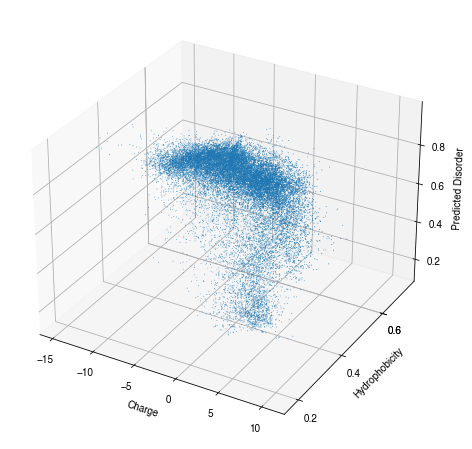

In [8]:
PublishedGcn4Data = pd.read_csv('../Data/Staller_2018data/Supplemental_DataTable1_ActivityData.csv')

DF = masterDF
#high light each perturbation
markersize = 1
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
# DF = Merged_ DF[Merged_DF.MutationClass=='Charge']
print( len(DF))
ax.scatter(DF.Charge,DF.HydrophobicityKD,DF.Disorder,label='Charge variants',color=darkblue,edgecolors='none',s=markersize)
# DF = Merged_DF[Merged_DF.MutationClass=='Hydrophobicity']
print( len(DF))
# ax.scatter(DF.Charge,DF.Hydrophobicity,DF.Disorder,label='Hydrophobicity variants',color=darkgreen,edgecolors='none',s=markersize)
# # DF = Merged_DF[Merged_DF.MutationClass=='Disorder']
# print( len(DF))
# ax.scatter(DF.Charge,DF.Hydrophobicity,DF.Disorder,label='Disorder variants',color=lightblue,edgecolors='none',s=markersize)
#DF = Merged_DF[Merged_DF.MutationClass=='Kappa']
#ax.scatter(DF.Charge,DF.Hydrophobicity,DF.Disorder,s=100,label='Kappa variants',color=pink)

# DATA_Gcn4_singleMuts = pickle.load(open('../AnalysisSupportFiles/Dump_Gcn4_singleMuts.txt','r')) # uses old 9 column format 
# ax.scatter( np.array(DATA_Gcn4_singleMuts[2])*44,DATA_Gcn4_singleMuts[3],DATA_Gcn4_singleMuts[7],color=lightgreen,edgecolors='none',s=markersize,label='Gcn4 Single mutants')

# gcn4 = pickle.load(open('../AnalysisSupportFiles/gcn4_wt','r'))
# ax.scatter(np.array(gcn4[0])*44,gcn4[1],gcn4[2],color='pink', label = 'WT GCN4',edgecolors='none')  


ax.set_xlim3d(-16, 12)
ax.set_ylim3d(.15,.75)
ax.set_zlim3d(.1, 1)
ax.set_xticks([-15,-10,-5,0,5,10])
ax.set_yticks([.2,.4,.6,.6])
ax.set_zticks([.2,.4,.6,.8])
ax.set_xlabel('Charge',fontsize=10)
ax.set_ylabel('Hydrophobicity',fontsize=10)
ax.set_zlabel('Predicted Disorder',fontsize=10)
# ax.legend()
# plt.savefig("Figures/PaperFigs/Gcn4_orthologs.pdf", transparent=True)
plt.show()

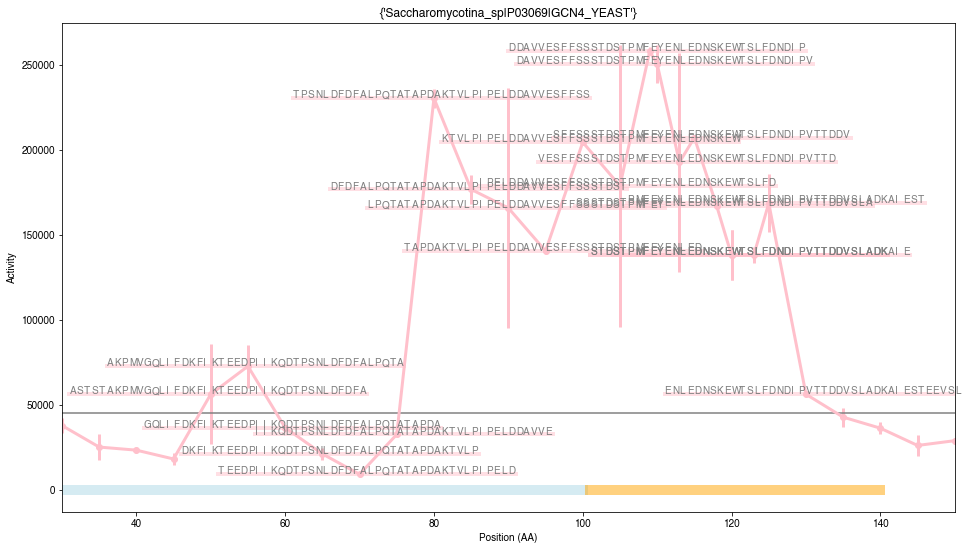

In [9]:
def ZoomPlot1TF(CurrentDF,filename,region=[60,150],plotScerInBackground=False):
    fig = plt.figure(figsize=[16,9])
    ax = fig.add_subplot(1,1,1)

    xmin,xmax = region

    if plotScerInBackground:
#         ax.plot(ScertempDF[x],ScertempDF[y],c='lightgray',linewidth=2,marker='s',label='S.cerevisiea activity')
        ax.errorbar(ScertempDF[x],ScertempDF[y],yerr=ScertempDF['Stdev_BioReps'],c='lightgray',linewidth=1,marker='o',mew=0,label='AD activity')

    ax.errorbar(CurrentDF[x],CurrentDF[y],yerr=CurrentDF['Stdev_BioReps'],c=tracecolor,linewidth=3,marker='o',label='AD activity')

    
    for i, entry in CurrentDF.iterrows():
        if ((entry[x]-halfwindow) >=xmin)&((entry[x]+halfwindow) <=xmax):
            ax.plot([entry[x]+1-halfwindow,entry[x]+1+halfwindow],[entry[y],entry[y]],linewidth=4,c=tracecolor,alpha=.5)
    #         print(i)
    #         if i in [39,42,43,44,47,50]:
            tile = entry.Seq
            if tile in set(ScertempDF.Seq):
                aacolor = 'gray'
            else:
                aacolor = 'black'
                
            for j, aa in enumerate(tile):
                ax.text(entry[x]+j-halfwindow+1,entry[y],aa,c=aacolor)
    ax.plot([-130,281],[ActivityThresh,ActivityThresh],c='gray')

    plt.xlim([xmin,xmax])

    for i in Gcn4Features.keys():
        x1,x2,color = Gcn4Features[i]
        ax.plot([x1,x2],[1,1],c=color,linewidth=10,alpha=.5,label=i)
    plt.xlabel('Position (AA)'),plt.ylabel('Activity')
    # plt.legend(loc=2)
    plt.title(set(CurrentDF.SpeciesNames))
    plt.savefig(filename)
    plt.show()
xmin,xmax = 30,150

ZoomPlot1TF(ScertempDF,'../Results/AnnotatedGcn4_Zoom_%i_%i.pdf'%(xmin,xmax),region=[xmin,xmax])

In [10]:
len(set(ScertempDF.Seq))
set(ScertempDF.SpeciesNames)
Sparadoxus
ScertempDF[0:60]

NameError: name 'Sparadoxus' is not defined

In [ ]:

Sparadoxus = MakeDF1Ortholog('Spar_spar361_g1.1')
ZoomPlot1TF(Sparadoxus,'Figures/AnnotatedGcn4Sparadoxus_Zoom.pdf',plotScerInBackground=True)
Sbayanus = MakeDF1Ortholog('Sbay_sbayc645_g44.1')
ZoomPlot1TF(Sbayanus,'Figures/AnnotatedGcn4Bayanus_Zoom.pdf',plotScerInBackground=True)
Skud = MakeDF1Ortholog('Skud_5.91')
ZoomPlot1TF(Skud,'Figures/AnnotatedGcn4Skud_Zoom.pdf',plotScerInBackground=True)

Smik = MakeDF1Ortholog('Smik_smik283_g1.1')
ZoomPlot1TF(Smik,'Figures/AnnotatedGcn4Smik_Zoom.pdf',plotScerInBackground=True)
Scas = MakeDF1Ortholog('Scas_Scas663.23')
ZoomPlot1TF(Scas,'Figures/AnnotatedGcn4Scas_Zoom.pdf')
# Suva = MakeDF1Ortholog('Suva_5.73')
# ZoomPlot1TF(Scas,'Figures/AnnotatedGcn4Suva_Zoom.pdf')


In [28]:
# pull out the sensu strictu

indx = (FullOrthoDF.SpeciesName=='Sbay_sbayc645_g44.1')|(FullOrthoDF.SpeciesName=='Skud_5.91')|(FullOrthoDF.SpeciesName=='Smik_smik283_g1.1')|(FullOrthoDF.SpeciesName=='Saccharomycotina_sp|P03069|GCN4_YEAST')|(FullOrthoDF.SpeciesName=='Spar_spar361_g1.1')
SensuStrictu = FullOrthoDF[indx]
indx = indx |(FullOrthoDF.SpeciesName=='Cgla_CAGL0L02475g')|(FullOrthoDF.SpeciesName=='Scas_Scas663.23')|(FullOrthoDF.SpeciesName=='KNAG0L00890')|(FullOrthoDF.SpeciesName=='Klac_KLLA0D14113g')
SensuStrictuPlus = FullOrthoDF[indx]





In [44]:
# plot locations of tiles on TF 

# sort the orthologs by length
FullOrthoDFsorted = FullOrthoDF.sort_values(by='Length',ascending=True)


def findMutant(mutname,cols=['shortname', 'MutName']):
    tempDF = masterDF
    for i, entry in tempDF.iterrows():
        tempname = entry.Name
        hits = re.search(mutname,tempname)
        if hits:
            print(entry[cols])
            
            

#for j, species in enumerate(testset):#

CropXaxis = False
def OverlayOrthologs(DF,SaveFigs=False,CropXaxis=False,ExtraFileName=''):
    fig = plt.figure(figsize=[12,8])
    ax = fig.add_subplot(1,1,1)
    k = 8
    ymin,ymax = min(Orthologs_DF.Activity),max(Orthologs_DF.Activity)
    x = 'NativeLocation'# 
    x = 'NormLocation'
    y = 'Activity'
    colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#fdbf6f','#ff7f00','#cab2d6','#ffff99','#6a3d9a','#b15928']
    color_Scer ='#e31a1c'
    halfwindow =20 # set to half the width of a tile if you want to plot the horizonal lines for each tile. set to 0 if you don't want horizontal liness
    Nperplot = min(10,len(DF))
    xmin, xmax = -110,150
    WTmean = 100000# set the location of the horizonal gray line 
    WTstd = 1#np.std(ScertempDF.Activity)

    for j, species in enumerate(DF.SpeciesName):
        indx = (Orthologs_DF.SpeciesNames==species)&(Orthologs_DF.Activity>0)
        tempXmin,tempXmax =xmin, xmax
        tempDF = Orthologs_DF[indx]
        tempDF2 = tempDF.sort_values(x,ascending=1)

        ax.plot(tempDF2[x],tempDF2[y],c=colors[j%Nperplot],linewidth=2,marker='o',label=species)
        tempXmin = min(min(tempDF2[x]),tempXmin)
        tempXmax = max(max(tempDF2[x]),tempXmax)
        #ax.scatter(tempDF2[x],tempDF2[y],c=colors[j%Nperplot])
        for i, entry in tempDF2.iterrows():
            ax.plot([entry[x]-halfwindow,entry[x]+halfwindow],[entry[y],entry[y]],linewidth=0.5,c=colors[j%Nperplot],alpha=.5)
        if (((j+1)%Nperplot) == 0):
            ax.plot(ScertempDF[x],ScertempDF[y],c=color_Scer,linewidth=2,marker='o',label='S. cerevisiae WT')
            #add back the lines for tile width
            for i, entry in ScertempDF.iterrows():
                ax.plot([entry[x]-halfwindow,entry[x]+halfwindow],[entry[y],entry[y]],c=color_Scer,linewidth=0.5,alpha=.5)
            WTstdPatch = mpatches.Rectangle((min(Orthologs_DF[x]),WTmean-WTstd),max(Orthologs_DF[x])-min(Orthologs_DF[x]),2*WTstd,alpha=0.3,facecolor='gray')
            if x =='NormLocation':
                plt.xlabel('Align on WxxLF motif')
            else:
                plt.xlabel("Align on Start")
            ax.plot([min(Orthologs_DF[x]),max(Orthologs_DF[x])],[WTmean,WTmean],c='gray')
            ax.legend(fontsize =8)
            #rescale axes
            plt.ylim([ymin, ymax])
            if CropXaxis:
                plt.xlim([xmin, xmax])
            if SaveFigs:
                plt.savefig('Figures/PaperFigs/Supp/Zoom_FewOrthologs_%i_%s.pdf'%(k,ExtraFileName))
            else:
                plt.xlim([tempXmin, tempXmax]), 
                plt.ylabel('Activity')
#                 plt.savefig('Figures/Ortholog_Locations/ChopOrthologs_%i.png'%k)
            k+=1
            plt.show()
            fig = plt.figure(figsize=[12,8])
            ax = fig.add_subplot(1,1,1)

    plt.show()


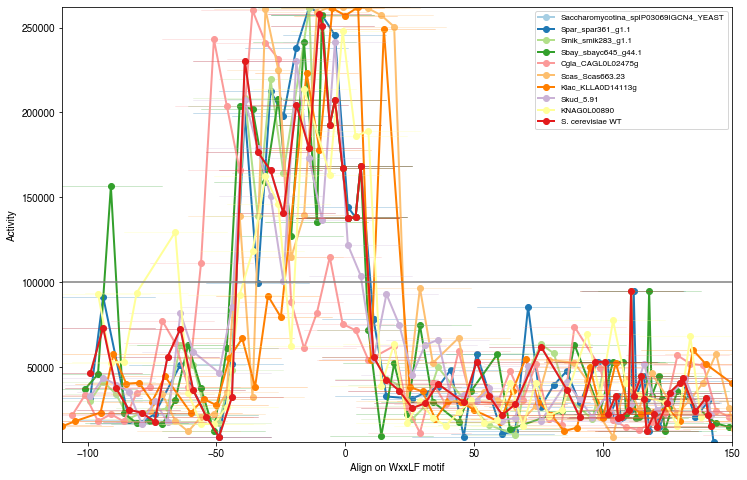

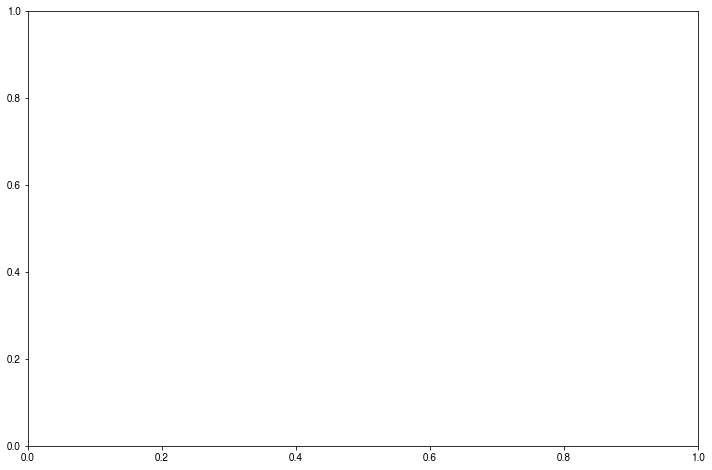

In [45]:
OverlayOrthologs(SensuStrictuPlus,CropXaxis=True)


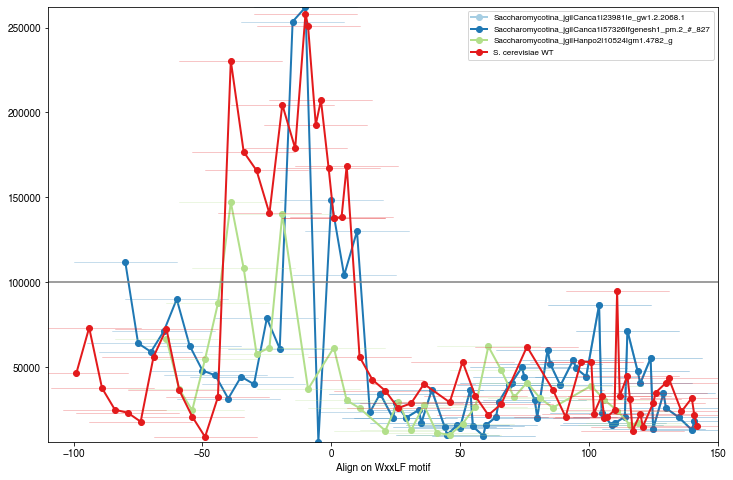

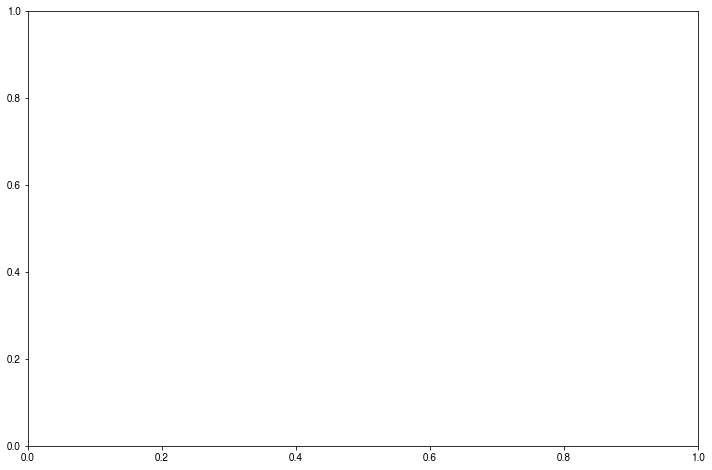

In [46]:
indx = (FullOrthoDF.SpeciesName=='Saccharomycotina_jgi|Canca1|57326|fgenesh1_pm.2_#_827')
indx = indx |(FullOrthoDF.SpeciesName=='Saccharomycotina_jgi|Canca1|23981|e_gw1.2.2068.1')
indx = indx |(FullOrthoDF.SpeciesName=='Saccharomycotina_jgi|Hanpo2|10524|gm1.4782_g')

InActiveAtWxxLF = FullOrthoDF[indx].reindex()
OverlayOrthologs(InActiveAtWxxLF,SaveFigs=True, CropXaxis=True, ExtraFileName='InactiveAtWxxLF')
# OverlayOrthologs(FullOrthoDFsorted)

In [ ]:
def findMutant(mutname,cols=['Name']):
#     indx = (masterDF[ad]==1)
    tempDF = masterDF#[indx]
    for i, entry in tempDF.iterrows():
        tempname = entry.Name
        hits = re.search(mutname,tempname)
        if hits:
            print (entry[cols])
findMutant('VP16')           
findMutant('Gnc4Lib')

In [ ]:
findMutant('VP16')

In [13]:
temp = MakeDF1Ortholog('Saccharomycotina_jgi|Hanpo2|10524|gm1.4782_g')
OverlayOrthologs(temp)

NameError: name 'OverlayOrthologs' is not defined